# ECG Exploration & ML Comparison
**Objectives**
1. Visualize example ECG records and 10s windows.
2. Extract handcrafted features (using `FeatureExtractor`).
3. Build a small in-memory dataset for Normal / AFib / MI.
4. Train & compare classical ML models (DT, RF, SVM, KNN, MLP).
5. Show metrics and confusion matrices.

Run cells sequentially.

In [1]:
# Imports & parameters
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# wfdb used to read records for plotting (Segmention also uses wfdb internally)
import wfdb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Use your package modules
from ecg_utils.segmenter import Segmention
from ecg_utils.feature_extractor import FeatureExtractor

# Notebook hyper-parameters (tweak for speed)
FS = 360
CHANNEL_INDEX = 0
MAX_RECORDS_PER_CLASS = 3      # change to 5 or more if you want larger dataset
DURATION_NORMAL_MI = 2        # minutes
DURATION_AFIB = 2             # for quick tests; set 6 if you want full 6 min AFib windows
RANDOM_STATE = 42


In [2]:
# Helper functions

def read_record_signal(base_dir, record_name, channel_index=0):
    """
    Read a record using wfdb and return the signal (1D numpy) and sampling rate.
    base_dir should be like 'data/normal' (no trailing slash recommended).
    record_name can include subfolders (e.g., 'patient014/s0046lre').
    """
    rec_path = os.path.join(base_dir, record_name)
    rec = wfdb.rdrecord(rec_path)
    signal = rec.p_signal[:, channel_index]
    fs = rec.fs
    return signal, fs

def plot_signal_segment(signal, fs, start_sec=0, length_sec=10, ax=None, title=None):
    start = int(start_sec * fs)
    end = int(start + length_sec * fs)
    t = np.arange(start, end) / fs
    if ax is None:
        plt.figure(figsize=(10,3))
        plt.plot(t, signal[start:end])
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        if title: plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        ax.plot(t, signal[start:end])
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude")
        if title: ax.set_title(title)

def build_dataset_in_memory(class_specs, fs=FS, channel_index=CHANNEL_INDEX,
                            duration_minutes_map=None, max_records_per_class=MAX_RECORDS_PER_CLASS):
    """
    class_specs: dict like {'normal': ('data/normal', ['16265','16272']), 'afib': ('data/afib', [...]), ...}
    duration_minutes_map: dict mapping class_name -> minutes to cut
    Returns: pandas DataFrame with all extracted windows features and 'label' column (string)
    """
    seg = Segmention(fs=fs)
    extractor = FeatureExtractor(fs=fs)
    rows = []
    for label, (base_dir, rec_list) in class_specs.items():
        n = 0
        dur_min = (duration_minutes_map or {}).get(label, 2)
        path_with_slash = base_dir if base_dir.endswith(os.sep) else base_dir + os.sep
        for rec in rec_list:
            if max_records_per_class and n >= max_records_per_class:
                break
            try:
                segments = seg.segment(path_with_slash, rec, channel_index, duration_minutes=dur_min)
                if not segments:
                    print(f"[WARN] no segments for {rec} in {label}")
                for w in segments:
                    try:
                        feat_df = extractor.compute_features(w)
                        feat_df['label'] = label
                        rows.append(feat_df)
                    except Exception as e:
                        print(f"[WARN] feature extraction failed for {rec}: {e}")
                n += 1
            except Exception as e:
                print(f"[ERROR] reading/segmenting {rec} in {label}: {e}")
    if rows:
        return pd.concat(rows, ignore_index=True)
    else:
        return pd.DataFrame()


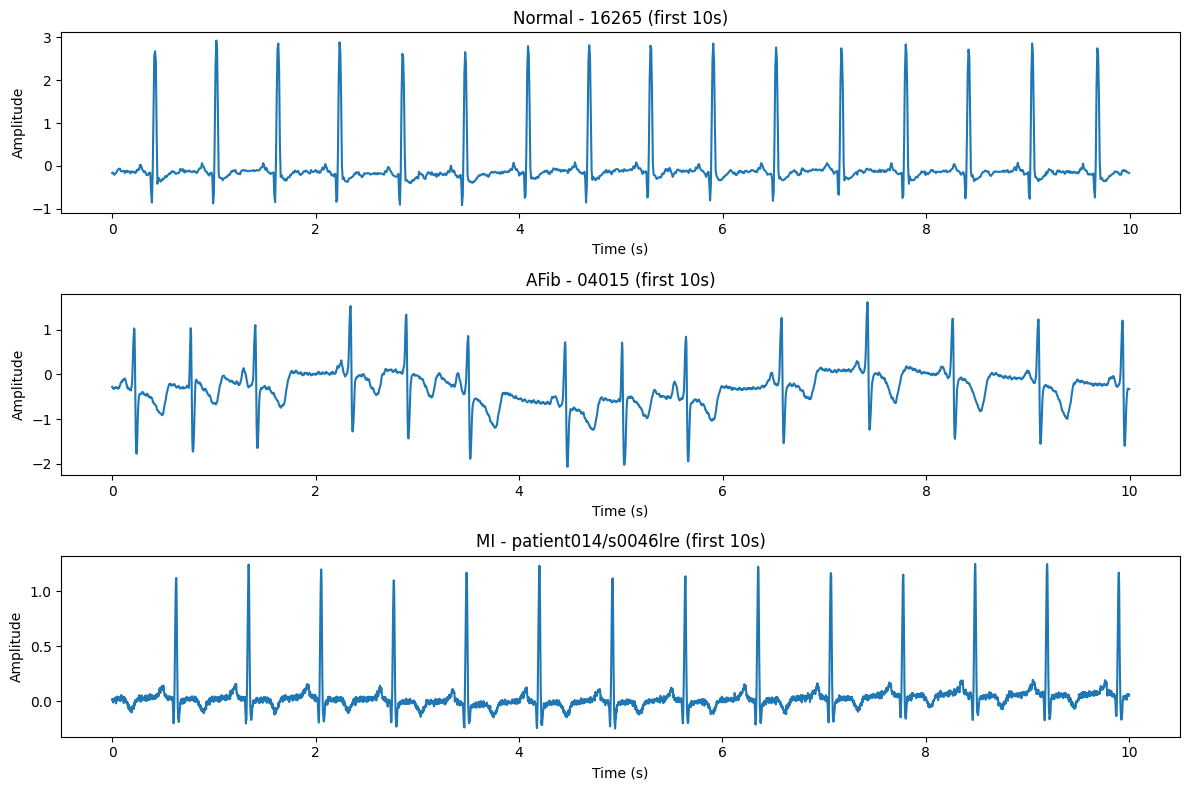

In [3]:
# Define small lists (use the same lists you used previously)
normal_records = ["16265","16272","16273"]
afib_records = ["04015","04043","04048"]
mi_records = ["patient014/s0046lre","patient013/s0045lre","patient006/s0022lre"]

# Plot one raw record from each class (first 10 seconds)
examples = [
    ("Normal", "data/normal", normal_records[0]),
    ("AFib", "data/afib", afib_records[0]),
    ("MI", "data/MI", mi_records[0])
]

plt.figure(figsize=(12, 8))
for i, (label, base_dir, rec) in enumerate(examples, 1):
    try:
        sig, fs = read_record_signal(base_dir, rec, channel_index=CHANNEL_INDEX)
        ax = plt.subplot(len(examples), 1, i)
        plot_signal_segment(sig, fs, start_sec=0, length_sec=10, ax=ax, title=f"{label} - {rec} (first 10s)")
    except Exception as e:
        print(f"[WARN] Could not plot {rec} from {base_dir}: {e}")
plt.tight_layout()
plt.show()


In [4]:
# Build dataset (this will call your Segmention & FeatureExtractor)
class_specs = {
    "Normal": ("data/normal", normal_records),
    "AFib": ("data/afib", afib_records),
    "MI": ("data/MI", mi_records)
}
duration_map = {"Normal": DURATION_NORMAL_MI, "MI": DURATION_NORMAL_MI, "AFib": DURATION_AFIB}

df = build_dataset_in_memory(class_specs, fs=FS, channel_index=CHANNEL_INDEX,
                             duration_minutes_map=duration_map, max_records_per_class=MAX_RECORDS_PER_CLASS)

print("Dataset shape:", df.shape)
print(df['label'].value_counts())
df.head()


Dataset shape: (108, 12)
label
Normal    36
AFib      36
MI        36
Name: count, dtype: int64


,RR_mean,RR_std,HR_mean,HR_std,RMSSD,QRS_mean,QT_mean,ST_amp_mean,ST_slope_mean,ST_amp_max,ST_amp_min,label
0,0.617407,0.017553,97.258795,2.753463,0.023146,85.925926,202.222222,0.242791,2.121783,0.282665,0.177921,Normal
1,0.627037,0.016275,95.752814,2.492950,0.021272,82.037037,205.370370,0.256993,2.131836,0.289282,0.203619,Normal
2,0.643452,0.023771,93.376237,3.501375,0.029448,85.317460,208.531746,0.265631,2.173969,0.342146,0.200768,Normal
3,0.632222,0.018110,94.983273,2.793929,0.020827,-551.190476,-420.039683,0.268682,2.120333,0.305598,0.230639,Normal
4,0.642037,0.016539,93.513475,2.366184,0.021746,86.481481,212.592593,0.262820,2.139278,0.321115,0.222179,Normal


In [5]:
# Prepare X,y
if df.empty:
    raise RuntimeError("No data found. Ensure 'data/' has the records and download step was run.")

# drop rows with NaNs possibly introduced by feature extraction
df_clean = df.dropna().reset_index(drop=True)

# features list (from your FeatureExtractor)
feature_cols = [c for c in df_clean.columns if c != 'label']
X = df_clean[feature_cols].values
y = df_clean['label'].values

# simple label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=RANDOM_STATE, stratify=y_enc)

print("Train/Test sizes:", X_train.shape, X_test.shape)


Train/Test sizes: (86, 11) (22, 11)


In [6]:
models = {
    "DecisionTree": make_pipeline(StandardScaler(with_mean=True), DecisionTreeClassifier(random_state=RANDOM_STATE)),
    "RandomForest": make_pipeline(StandardScaler(with_mean=True), RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)),
    "SVM": make_pipeline(StandardScaler(with_mean=True), SVC(probability=True, random_state=RANDOM_STATE)),
    "KNN": make_pipeline(StandardScaler(with_mean=True), KNeighborsClassifier(n_neighbors=5)),
    "MLP": make_pipeline(StandardScaler(with_mean=True), MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=RANDOM_STATE))
}

results = []
fitted_models = {}

for name, model in models.items():
    print(f"\nTraining {name} ...")
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        print(f"{name} — Acc: {acc:.3f}, F1(macro): {f1:.3f}")
        print(classification_report(y_test, y_pred, target_names=le.classes_))
        results.append({"model": name, "accuracy": acc, "f1_macro": f1})
        fitted_models[name] = model
    except Exception as e:
        print(f"[ERROR] {name} training failed: {e}")

results_df = pd.DataFrame(results).sort_values("f1_macro", ascending=False).reset_index(drop=True)
results_df



Training DecisionTree ...
DecisionTree — Acc: 0.909, F1(macro): 0.908
              precision    recall  f1-score   support

        AFib       0.86      0.86      0.86         7
          MI       0.88      1.00      0.93         7
      Normal       1.00      0.88      0.93         8

    accuracy                           0.91        22
   macro avg       0.91      0.91      0.91        22
weighted avg       0.91      0.91      0.91        22


Training RandomForest ...
RandomForest — Acc: 0.909, F1(macro): 0.908
              precision    recall  f1-score   support

        AFib       0.86      0.86      0.86         7
          MI       0.88      1.00      0.93         7
      Normal       1.00      0.88      0.93         8

    accuracy                           0.91        22
   macro avg       0.91      0.91      0.91        22
weighted avg       0.91      0.91      0.91        22


Training SVM ...
SVM — Acc: 0.818, F1(macro): 0.818
              precision    recall  f1-score

,model,accuracy,f1_macro
0,MLP,0.909091,0.910714
1,DecisionTree,0.909091,0.907937
2,RandomForest,0.909091,0.907937
3,SVM,0.818182,0.817521
4,KNN,0.818182,0.814744


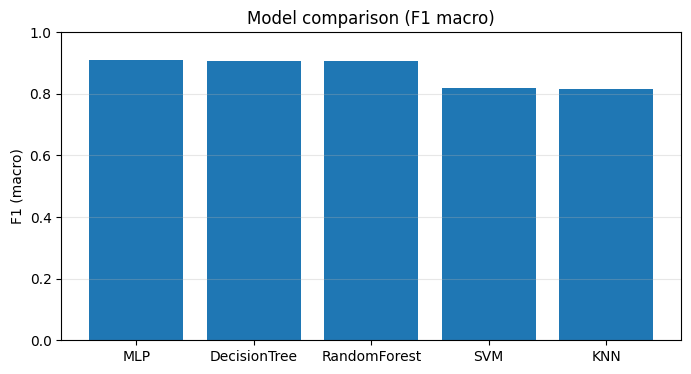

In [7]:
# Simple bar plot of F1 scores
plt.figure(figsize=(8,4))
plt.bar(results_df['model'], results_df['f1_macro'])
plt.ylabel("F1 (macro)")
plt.ylim(0,1)
plt.title("Model comparison (F1 macro)")
plt.grid(axis='y', alpha=0.3)
plt.show()


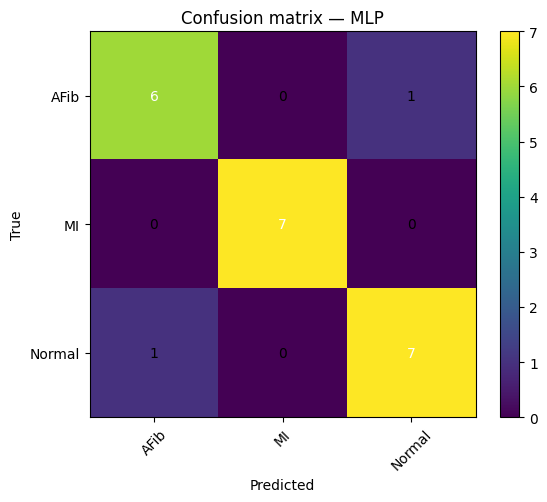

In [8]:
# Confusion matrix for best model
best_name = results_df.loc[0, 'model']
best_model = fitted_models[best_name]
y_best_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_best_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion matrix — {best_name}")
plt.colorbar()
ticks = np.arange(len(le.classes_))
plt.xticks(ticks, le.classes_, rotation=45)
plt.yticks(ticks, le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.tight_layout()
plt.show()
